In [1]:
import multimodal_cci as mmcci

2024-05-02 12:04:29.139160: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 12:04:29.279974: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-02 12:04:29.283894: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-02 12:04:29.283919: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc

In [2]:
import pickle

with open('../data/melanoma_data.pkl', 'rb') as f:
    melanoma_data = pickle.load(f)

In [3]:
from matplotlib import pyplot as plt

colors = {
    'Endothelial': plt.colormaps.get_cmap('tab20').colors[0],
    'Fibroblast': plt.colormaps.get_cmap('tab20').colors[1],
    'KC Differentiating': plt.colormaps.get_cmap('tab20').colors[2],
    'KC Cycling': plt.colormaps.get_cmap('tab20').colors[3],
    'KC Basal': plt.colormaps.get_cmap('tab20').colors[4],
    'KC Other': plt.colormaps.get_cmap('tab20').colors[5],
    'NK + T': plt.colormaps.get_cmap('tab20').colors[6],
    'B + PDC': plt.colormaps.get_cmap('tab20').colors[7],
    'Melanocyte': plt.colormaps.get_cmap('tab20').colors[8],
    'Myeloid': plt.colormaps.get_cmap('tab20').colors[9],
    'Pilosebaceous': plt.colormaps.get_cmap('tab20').colors[10],
    'NotDet': plt.colormaps.get_cmap('tab20').colors[11],
}

In [4]:
cell_type_replacements = {
    'KC.Basal': 'KC Basal',
    'KC_Basal': 'KC Basal',
    'KC.Cycling': 'KC Cycling',
    'KC_Cyc': 'KC Cycling',
    'KC_Diff': 'KC Differentiating',
    'KC_Other': 'KC Other',
    'NK.T': 'NK + T',
    'B.PDC': 'B + PDC',
    'B...PDC': 'B + PDC',
}

visium_cci = [mmcci.tl.rename_celltypes(sample, cell_type_replacements) for sample in melanoma_data['visium_cci']]
cosmx_cci = [mmcci.tl.rename_celltypes(sample, cell_type_replacements) for sample in melanoma_data['cosmx_cci']]
xenium_cci = [mmcci.tl.rename_celltypes(sample, cell_type_replacements) for sample in melanoma_data['xenium_cci']]

visium_pvals = [mmcci.tl.rename_celltypes(sample, cell_type_replacements) for sample in melanoma_data['visium_pvals']]
cosmx_pvals = [mmcci.tl.rename_celltypes(sample, cell_type_replacements) for sample in melanoma_data['cosmx_pvals']]
xenium_pvals = [mmcci.tl.rename_celltypes(sample, cell_type_replacements) for sample in melanoma_data['xenium_pvals']]

#### Normalise each group of samples

In [5]:
visium_normalised = mmcci.it.normalise_within_tech(visium_cci, melanoma_data['visium_sizes'])
xenium_normalised = mmcci.it.normalise_within_tech(xenium_cci, melanoma_data['xenium_sizes'])
cosmx_normalised = mmcci.it.normalise_within_tech(cosmx_cci, melanoma_data['cosmx_sizes'])

#### Integrate Patients

- 6747: vis4, cosmx1
- 21031: vis2, cosmx2, cosmx3
- 48974: vis1, cosmx4, cosmx5, cosmx6
- 66487: vis3, cosmx7, cosmx8



In [6]:
p6747 = {
    'vis': [visium_normalised[3]],
    'cos': [cosmx_normalised[0]],
}

p21031 = {
    'vis': [visium_normalised[1]],
    'cos': [cosmx_normalised[1], cosmx_normalised[2]],
}

p48974 = {
    'vis': [visium_normalised[0]],
    'cos': [cosmx_normalised[3], cosmx_normalised[4], cosmx_normalised[5]],
}

p66487 = {
    'vis': [visium_normalised[2]],
    'cos': [cosmx_normalised[6], cosmx_normalised[7]],
}

patients = {"6747": p6747, "21031": p21031, "48974": p48974, "66487": p66487}

P6747_pvals = {
    'vis': [visium_pvals[3]],
    'cos': [cosmx_pvals[0]],
}

P21031_pvals = {
    'vis': [visium_pvals[1]],
    'cos': [cosmx_pvals[1], cosmx_pvals[2]],
}

P48974_pvals = {
    'vis': [visium_pvals[0]],
    'cos': [cosmx_pvals[3], cosmx_pvals[4], cosmx_pvals[5]],
}

P66487_pvals = {
    'vis': [visium_pvals[2]],
    'cos': [cosmx_pvals[6], cosmx_pvals[7]],
}

mel_patients_pvals = {"6747": P6747_pvals, "21031": P21031_pvals, "48974": P48974_pvals, "66487": P66487_pvals}

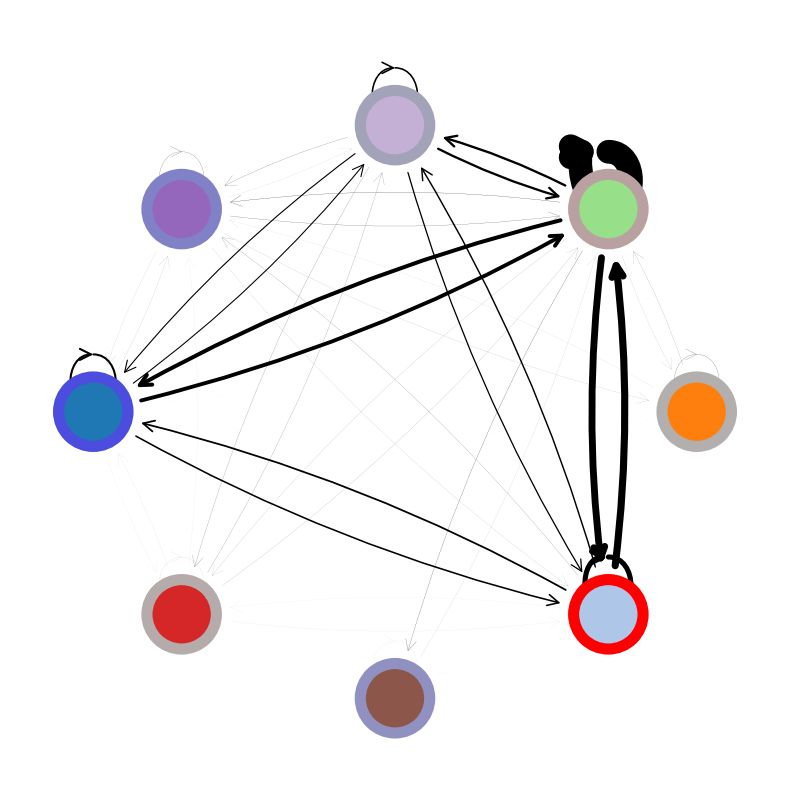

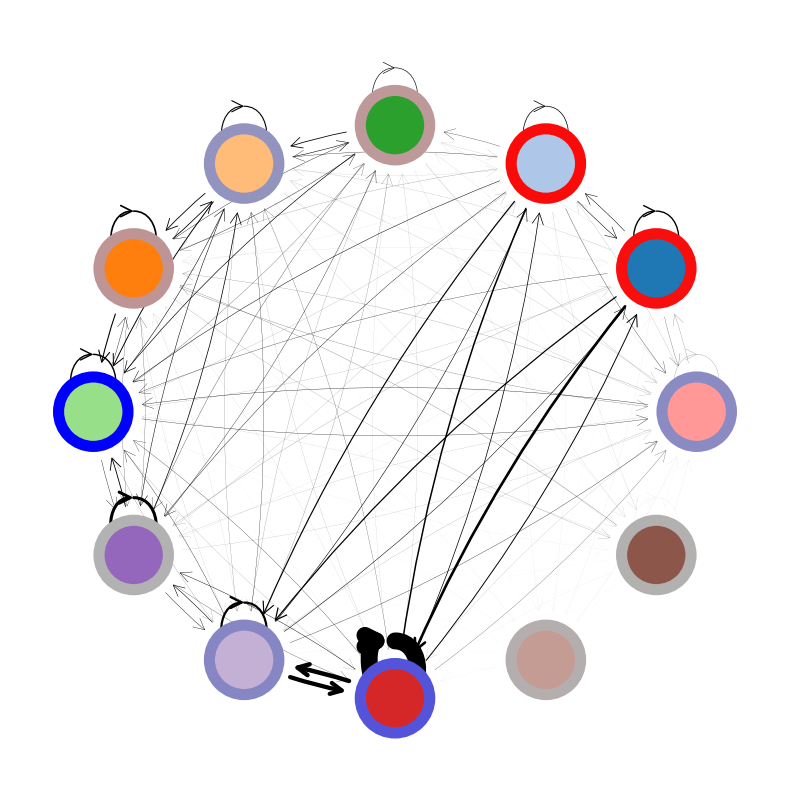

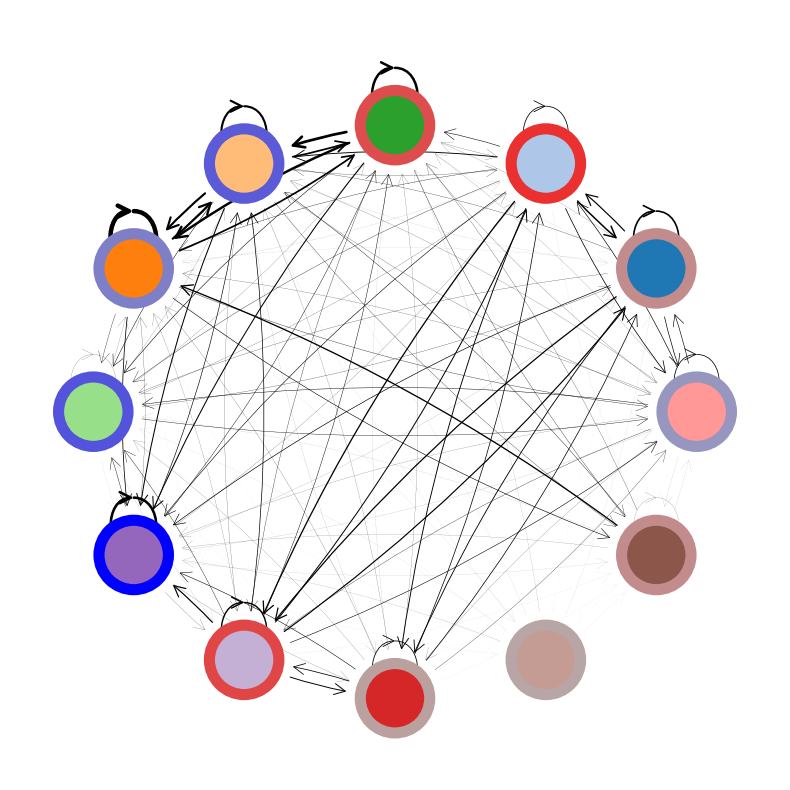

In [8]:
# mmcci.plt.network_plot(mmcci.it.calculate_overall_interactions(visium_normalised[1]), edge_weight=40, text_size=20, node_label_dist=1.1)
# mmcci.plt.network_plot(mmcci.it.calculate_overall_interactions(cosmx_normalised[1]), edge_weight=40, text_size=20, node_label_dist=1.1)
# mmcci.plt.network_plot(mmcci.it.calculate_overall_interactions(cosmx_normalised[2]), edge_weight=40, text_size=20, node_label_dist=1.1)

mmcci.plt.network_plot(mmcci.it.calculate_overall_interactions(visium_normalised[1]), show_labels=False, node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors)
mmcci.plt.network_plot(mmcci.it.calculate_overall_interactions(cosmx_normalised[1]), show_labels=False, node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors)
mmcci.plt.network_plot(mmcci.it.calculate_overall_interactions(cosmx_normalised[2]), show_labels=False, node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors)

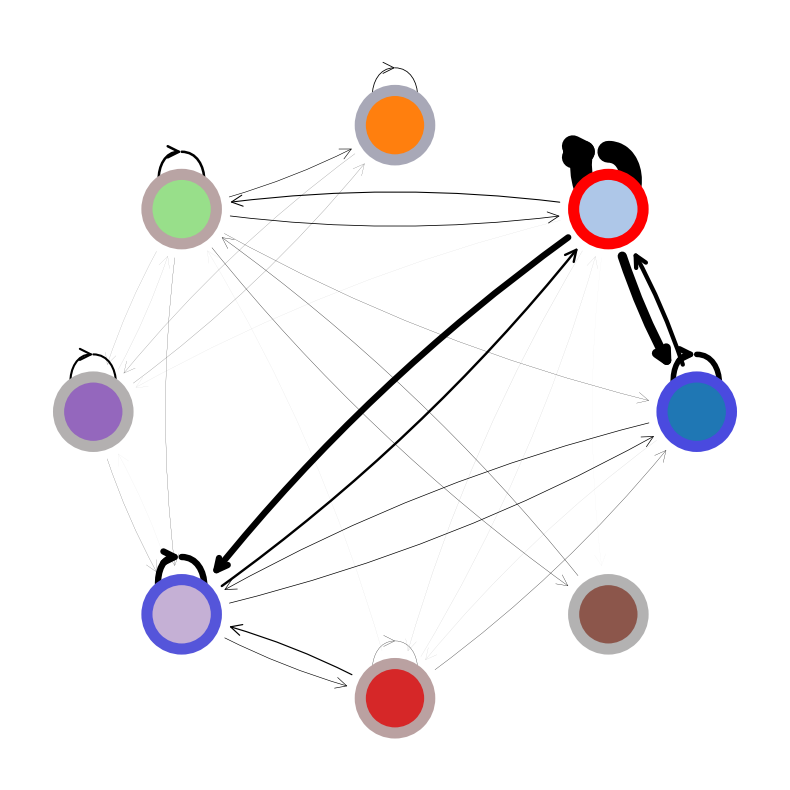

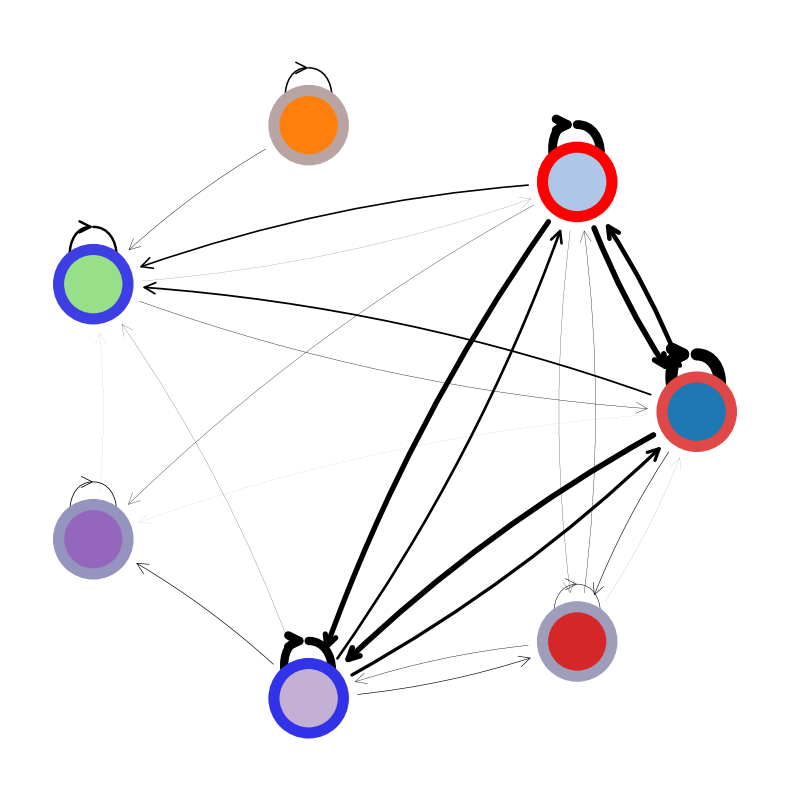

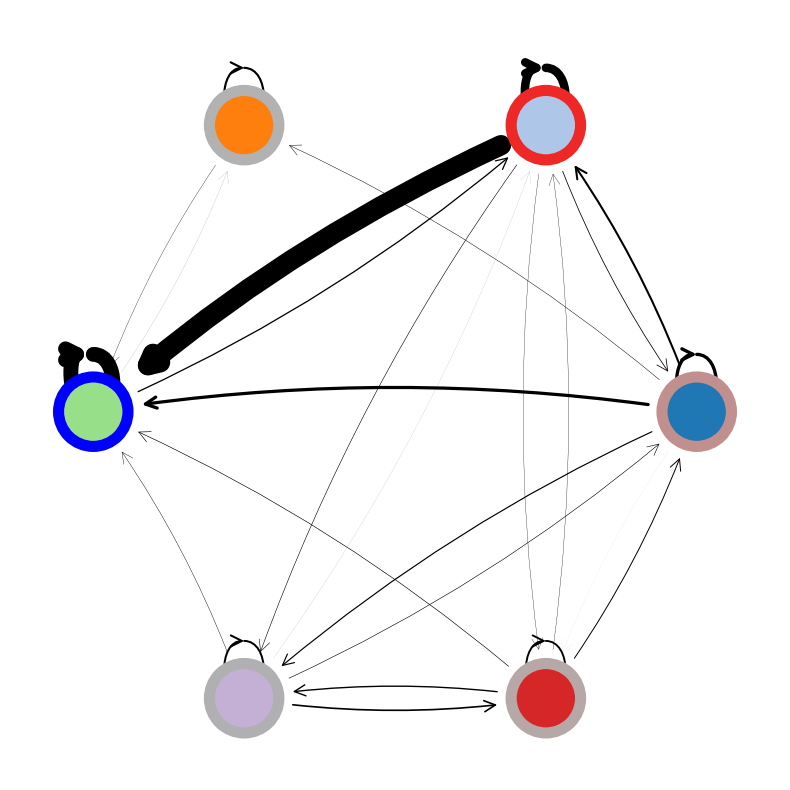

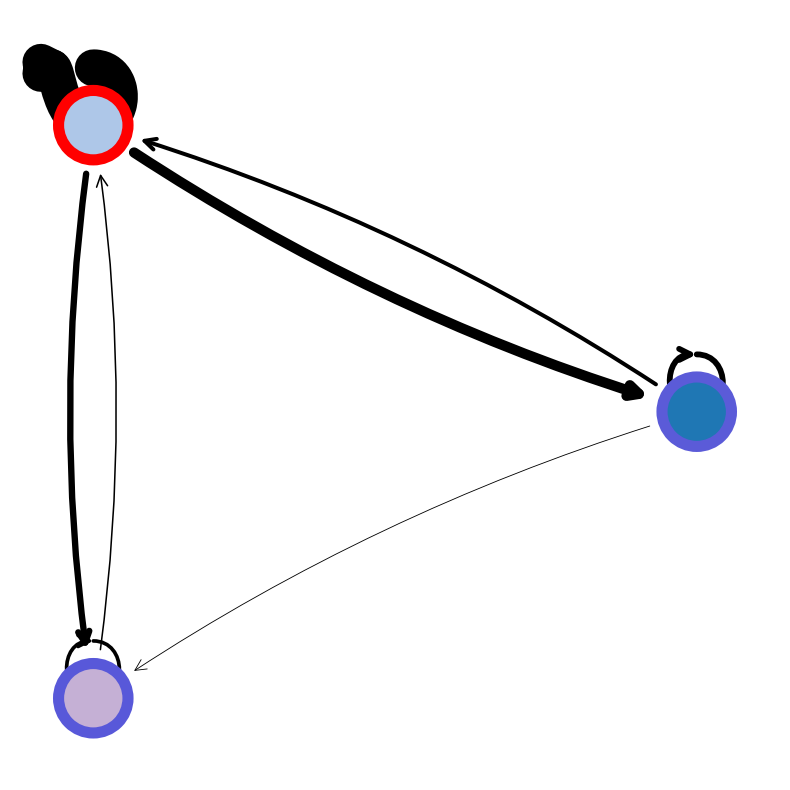

In [9]:
patient_integrated = {}

for patient, samples in patients.items():
    for tech in patients[patient].keys():
        if len(samples[tech]) >= 2:
            samples[tech] = mmcci.it.integrate_samples(samples[tech])
        else:
            samples[tech] = samples[tech][0]
    normalised = mmcci.it.normalise_between_tech([samples['vis'], samples['cos']])
    integrated = mmcci.it.integrate_samples(normalised, method=">=50%")
    patient_integrated[patient] = integrated
    
patient_pvals = {}
for patient, samples in mel_patients_pvals.items():
    sample_list = []
    for tech in mel_patients_pvals[patient].keys():
        sample_list.extend(samples[tech])
    patient_pvals[patient] = mmcci.it.integrate_p_vals(sample_list)
    
mel_patient_integrated_filtered = {}

for patient in patient_integrated.keys():
    mel_patient_integrated_filtered[patient] = mmcci.it.remove_insignificant(patient_integrated[patient], patient_pvals[patient])
    mmcci.plt.network_plot(mmcci.it.calculate_overall_interactions(mel_patient_integrated_filtered[patient]), show_labels=False, node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors)

#### Integrate within tech

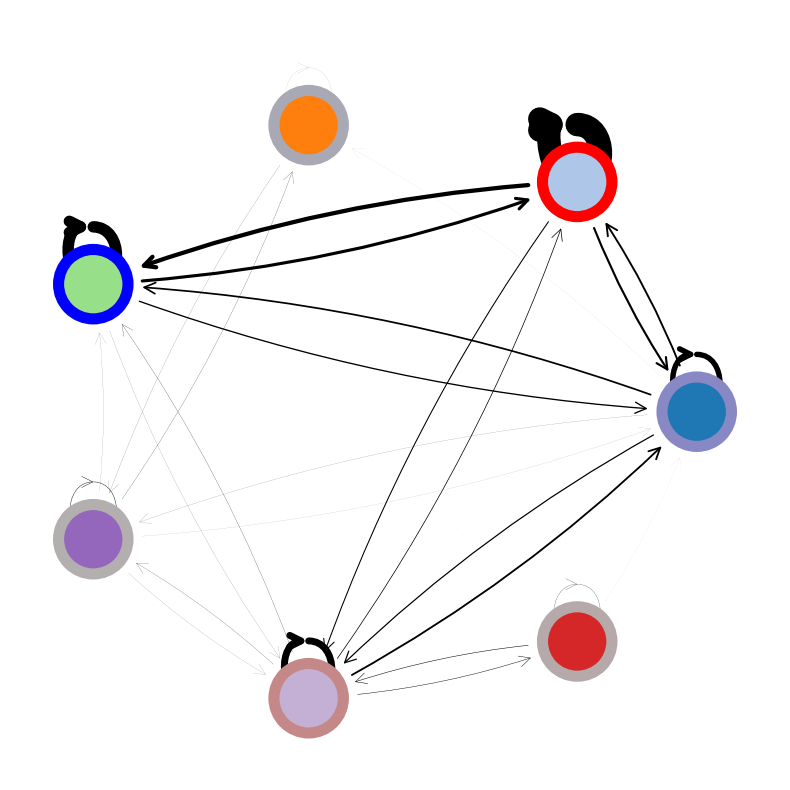

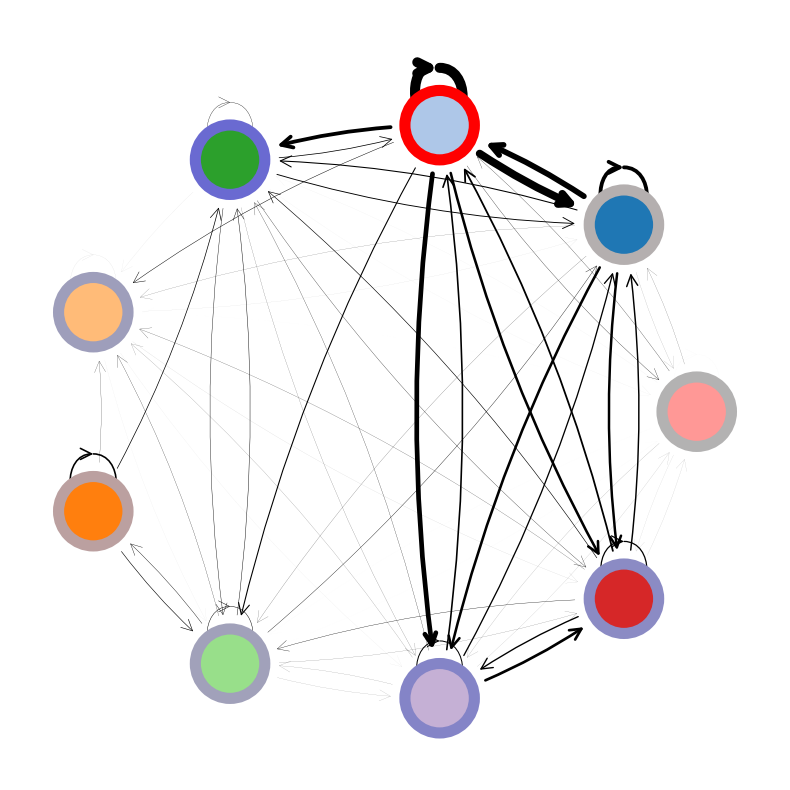

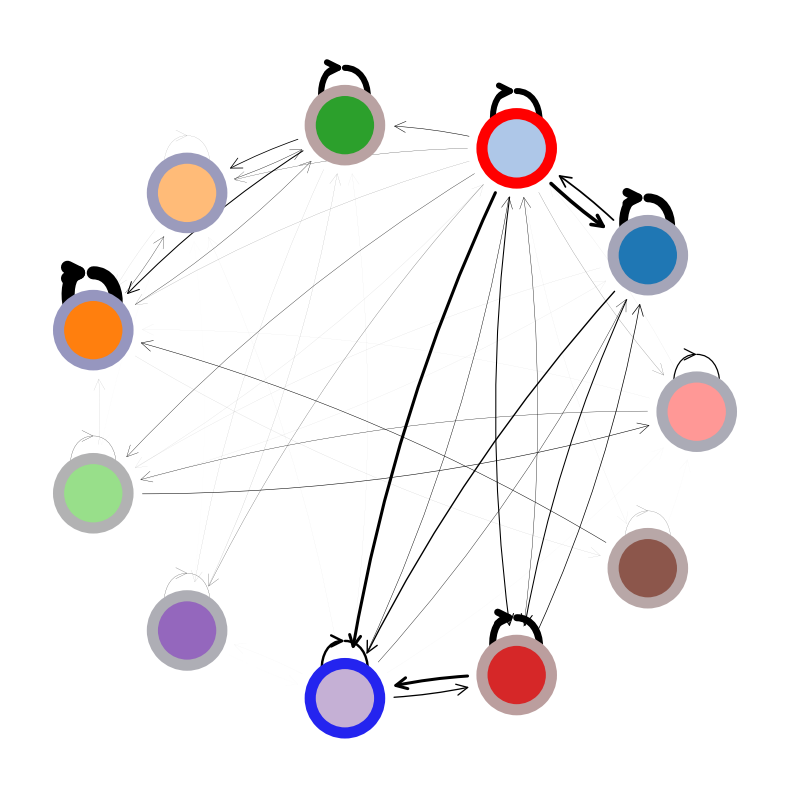

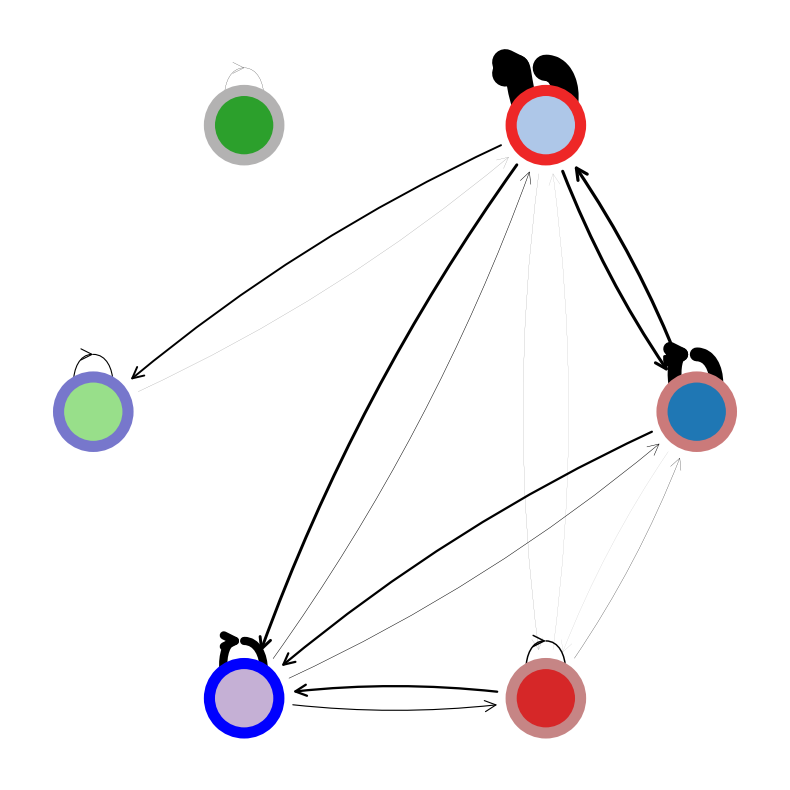

In [10]:
integrated_tech = {}
overall = {}

for tech, samples in zip(['vis', 'xen', 'cos'], [visium_normalised, xenium_normalised, cosmx_normalised]):
    integrated_tech[tech] = mmcci.it.integrate_samples(samples, method=">=50%")
    
    if tech == 'vis':
        p_vals = mmcci.it.integrate_p_vals(visium_pvals)
    elif tech == 'xen':
        p_vals = mmcci.it.integrate_p_vals(xenium_pvals)
    else:
        p_vals = mmcci.it.integrate_p_vals(cosmx_pvals)
        
    integrated = mmcci.it.remove_insignificant(integrated_tech[tech], p_vals)
    overall[tech] = mmcci.it.calculate_overall_interactions(integrated)
    mmcci.plt.network_plot(overall[tech], show_labels=False, node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors)
    
normalised = mmcci.it.normalise_between_tech(
    [integrated_tech['vis'], integrated_tech['xen'], integrated_tech['cos']]
    )

integrated = mmcci.it.integrate_samples(normalised)
p_vals = mmcci.it.integrate_p_vals(visium_pvals + xenium_pvals + cosmx_pvals)
integrated = mmcci.it.remove_insignificant(integrated, p_vals)
overall = mmcci.it.calculate_overall_interactions(integrated)
mmcci.plt.network_plot(overall, show_labels=False, node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors)

#### Get LR pairs from Fibroblast to Endothelial

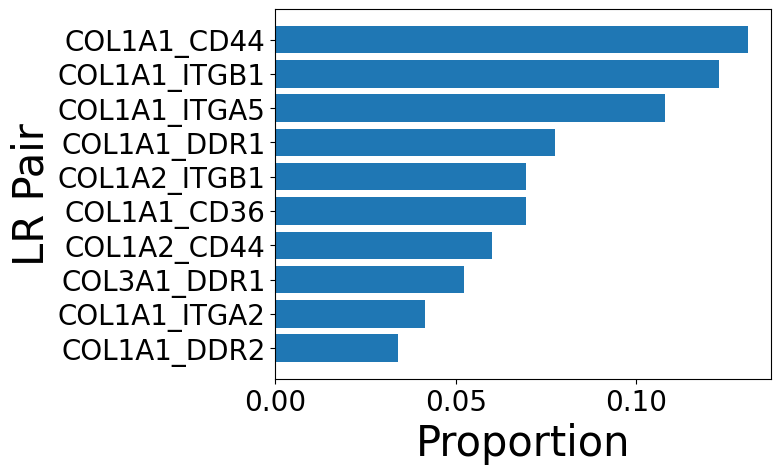

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Proteoglycans in cancer,11/205,1.070450e-14,1.220313e-12,0,0,53.390771,1717.480284,COL1A1;ITGB1;COL1A2;ITGA2;ITGA5;MET;TLR4;DCN;C...
1,KEGG_2021_Human,ECM-receptor interaction,8/88,9.785643e-13,5.577816e-11,0,0,82.866667,2291.486237,COL1A1;ITGB1;COL1A2;ITGA2;ITGA5;CD36;THBS2;CD44
2,KEGG_2021_Human,Human papillomavirus infection,10/331,6.287520e-11,2.374232e-09,0,0,27.820731,653.505328,COL1A1;ITGB1;NOTCH2;NOTCH3;JAG1;COL1A2;ITGA2;I...
3,KEGG_2021_Human,Phagosome,8/152,8.330638e-11,2.374232e-09,0,0,45.888889,1065.012094,ITGB1;ITGA2;ITGA5;CD14;CD36;THBS2;TLR4;TLR2
4,KEGG_2021_Human,PI3K-Akt signaling pathway,10/354,1.213454e-10,2.766674e-09,0,0,25.930233,592.048936,COL1A1;ITGB1;COL1A2;ITGA2;ITGA5;THBS2;MET;TLR4...
...,...,...,...,...,...,...,...,...,...,...
138,MSigDB_Hallmark_2020,IL-2/STAT5 Signaling,1/199,2.740277e-01,2.752010e-01,0,0,3.220919,4.169563,CD44
139,MSigDB_Hallmark_2020,G2-M Checkpoint,1/200,2.752010e-01,2.752010e-01,0,0,3.204571,4.134710,NOTCH2
140,MSigDB_Hallmark_2020,Adipogenesis,1/200,2.752010e-01,2.752010e-01,0,0,3.204571,4.134710,CD36
141,MSigDB_Hallmark_2020,mTORC1 Signaling,1/200,2.752010e-01,2.752010e-01,0,0,3.204571,4.134710,CXCR4


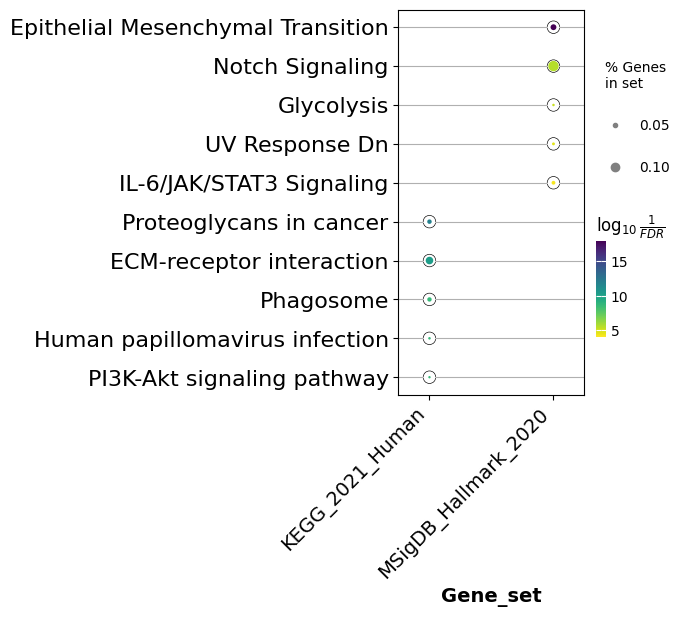

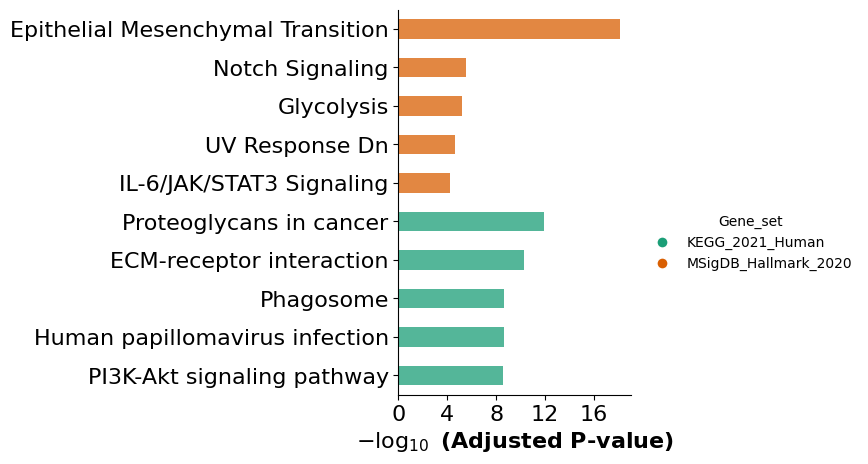

In [11]:
mmcci.plt.lrs_per_celltype(integrated, "Fibroblast", "Endothelial", n=10, x_label_size=30, y_label_size=30)

pairs = mmcci.an.get_lrs_per_celltype(integrated, "Fibroblast", "Endothelial")
mmcci.an.run_gsea(None, lrs=pairs, gene_sets=["KEGG_2021_Human", "MSigDB_Hallmark_2020"])

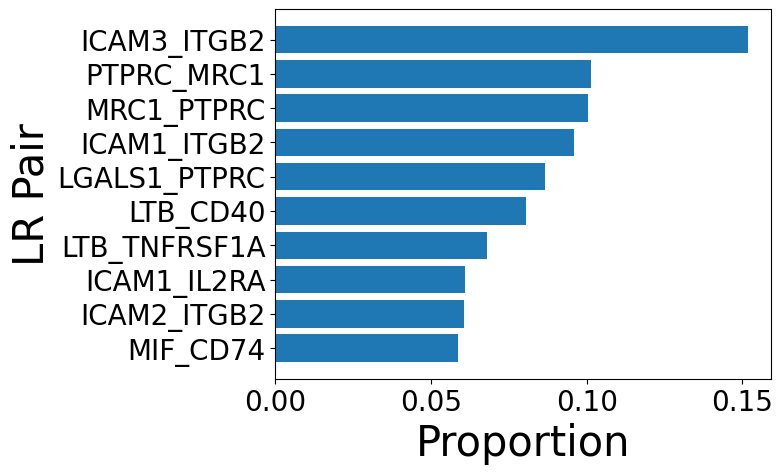

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Cytokine-cytokine receptor interaction,9/295,1.265953e-12,9.747838e-11,0,0,68.867133,1886.628601,CD40;CD4;IL2RA;IL16;CCR7;LTB;CCL19;CCR10;TNFRSF1A
1,KEGG_2021_Human,Cell adhesion molecules,7/148,3.130421e-11,1.205212e-09,0,0,89.546744,2165.891148,CD40;CD4;PTPRC;ITGB2;ICAM2;ICAM3;ICAM1
2,KEGG_2021_Human,Viral protein interaction with cytokine and cy...,5/100,2.298253e-08,4.313839e-07,0,0,80.514170,1416.126002,IL2RA;CCR7;CCL19;CCR10;TNFRSF1A
3,KEGG_2021_Human,Human T-cell leukemia virus 1 infection,6/219,2.677027e-08,4.313839e-07,0,0,46.406103,809.135608,CD40;CD4;IL2RA;ITGB2;ICAM1;TNFRSF1A
4,KEGG_2021_Human,NF-kappa B signaling pathway,5/104,2.801194e-08,4.313839e-07,0,0,77.245532,1343.348844,CD40;LTB;CCL19;ICAM1;TNFRSF1A
...,...,...,...,...,...,...,...,...,...,...
89,MSigDB_Hallmark_2020,Hypoxia,1/200,1.655504e-01,1.655504e-01,0,0,5.847768,10.517093,MIF
90,MSigDB_Hallmark_2020,Glycolysis,1/200,1.655504e-01,1.655504e-01,0,0,5.847768,10.517093,MIF
91,MSigDB_Hallmark_2020,KRAS Signaling Up,1/200,1.655504e-01,1.655504e-01,0,0,5.847768,10.517093,ITGB2
92,MSigDB_Hallmark_2020,mTORC1 Signaling,1/200,1.655504e-01,1.655504e-01,0,0,5.847768,10.517093,ITGB2


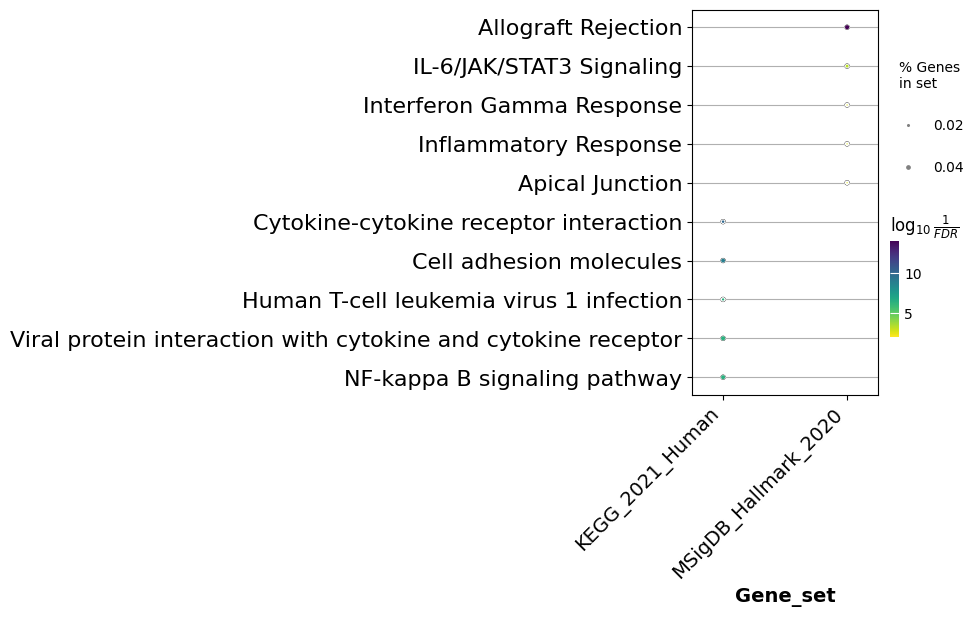

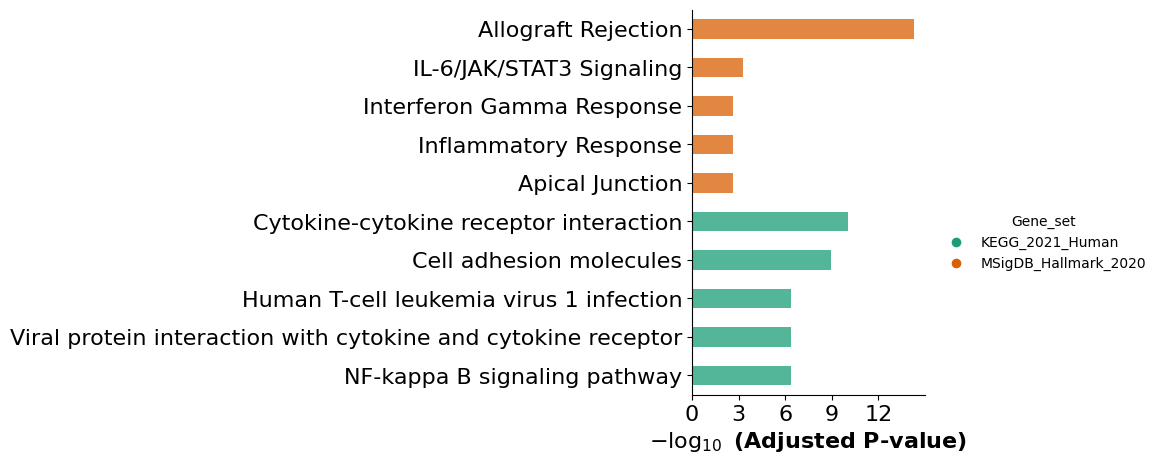

In [12]:
mmcci.plt.lrs_per_celltype(integrated, "NK + T", "Myeloid", n=10, x_label_size=30, y_label_size=30)

pairs = mmcci.an.get_lrs_per_celltype(integrated, "NK + T", "Myeloid")
mmcci.an.run_gsea(None, lrs=pairs, gene_sets=["KEGG_2021_Human", "MSigDB_Hallmark_2020"])

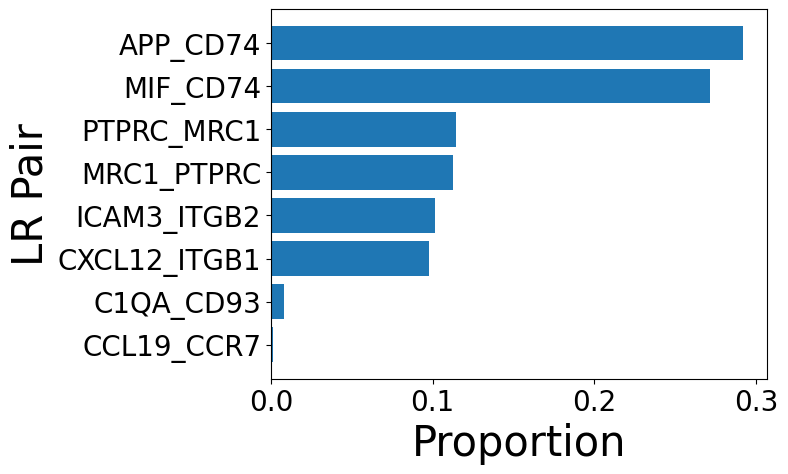

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Cell adhesion molecules,4/148,0.000002,0.000113,0,0,61.243827,805.076092,ITGB1;PTPRC;ITGB2;ICAM3
1,KEGG_2021_Human,Pertussis,3/76,0.000015,0.000426,0,0,81.838356,910.819408,ITGB1;C1QA;ITGB2
2,KEGG_2021_Human,Viral protein interaction with cytokine and cy...,3/100,0.000033,0.000647,0,0,61.515464,633.949335,CXCL12;CCR7;CCL19
3,KEGG_2021_Human,Leukocyte transendothelial migration,3/114,0.000049,0.000717,0,0,53.718919,532.567024,ITGB1;CXCL12;ITGB2
4,KEGG_2021_Human,Phagosome,3/152,0.000116,0.001350,0,0,39.942282,361.817975,ITGB1;ITGB2;MRC1
...,...,...,...,...,...,...,...,...,...,...
73,MSigDB_Hallmark_2020,KRAS Signaling Up,1/200,0.122513,0.122513,0,0,8.286432,17.397666,ITGB2
74,MSigDB_Hallmark_2020,Interferon Gamma Response,1/200,0.122513,0.122513,0,0,8.286432,17.397666,CD74
75,MSigDB_Hallmark_2020,Complement,1/200,0.122513,0.122513,0,0,8.286432,17.397666,C1QA
76,MSigDB_Hallmark_2020,mTORC1 Signaling,1/200,0.122513,0.122513,0,0,8.286432,17.397666,ITGB2


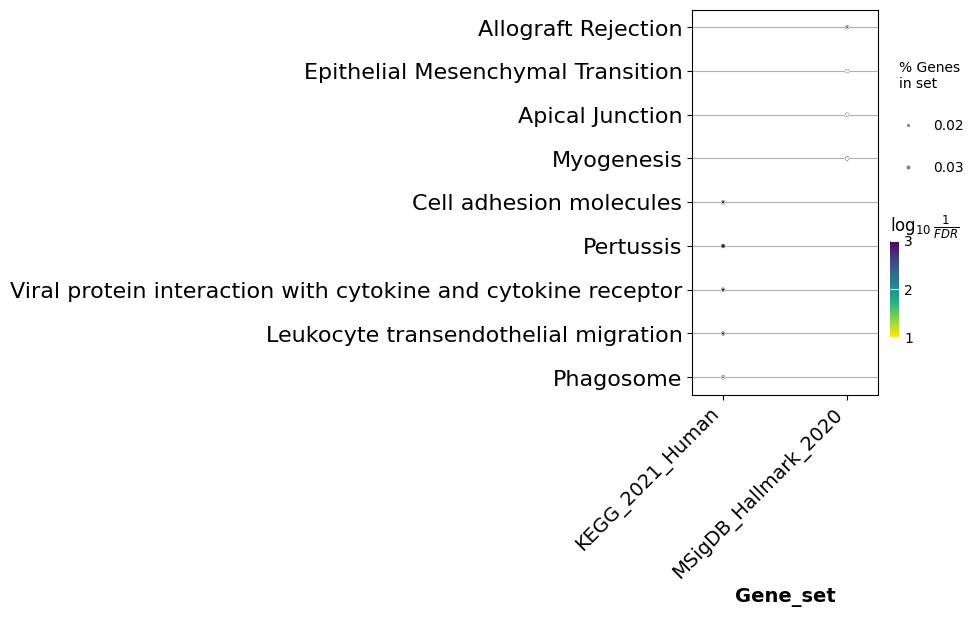

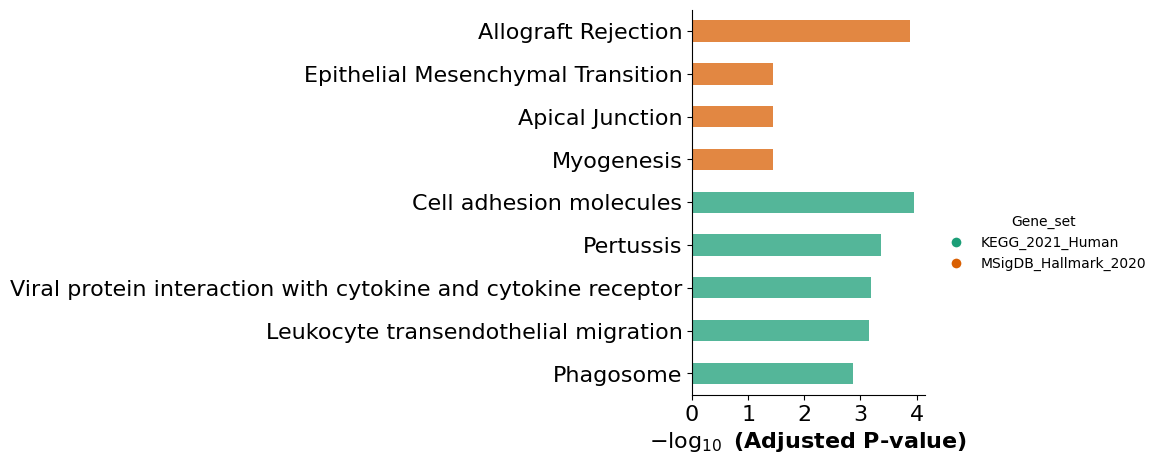

In [13]:
mmcci.plt.lrs_per_celltype(integrated, "Myeloid", "Endothelial", n=10, x_label_size=30, y_label_size=30)

pairs = mmcci.an.get_lrs_per_celltype(integrated, "Myeloid", "Endothelial")
mmcci.an.run_gsea(None, lrs=pairs, gene_sets=["KEGG_2021_Human", "MSigDB_Hallmark_2020"])

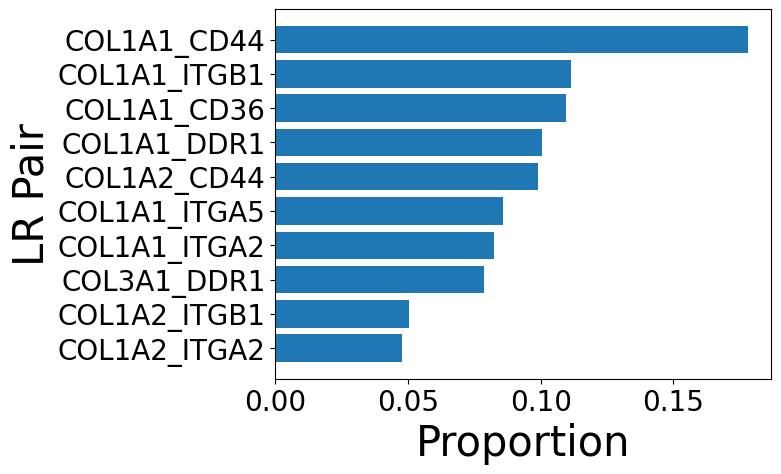

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,ECM-receptor interaction,7/88,1.946004e-14,1.089762e-12,0,0,344.071605,10862.482694,ITGB1;COL1A1;COL1A2;ITGA2;ITGA5;CD36;CD44
1,KEGG_2021_Human,Proteoglycans in cancer,8/205,5.075433e-14,1.421121e-12,0,0,200.923858,6150.636839,ITGB1;COL1A1;COL1A2;ITGA2;ITGA5;DCN;CD44;TLR2
2,KEGG_2021_Human,Platelet activation,5/124,6.460427e-09,1.205946e-07,0,0,119.261705,2248.985994,ITGB1;COL1A1;COL3A1;COL1A2;ITGA2
3,KEGG_2021_Human,Phagosome,5/152,1.800574e-08,2.520804e-07,0,0,96.409135,1719.223132,ITGB1;ITGA2;ITGA5;CD36;TLR2
4,KEGG_2021_Human,PI3K-Akt signaling pathway,6/354,2.489626e-08,2.788381e-07,0,0,56.436782,988.126117,ITGB1;COL1A1;COL1A2;ITGA2;ITGA5;TLR2
...,...,...,...,...,...,...,...,...,...,...
72,MSigDB_Hallmark_2020,Estrogen Response Early,1/200,1.136443e-01,1.136443e-01,0,0,9.040201,19.659557,CD44
73,MSigDB_Hallmark_2020,Estrogen Response Late,1/200,1.136443e-01,1.136443e-01,0,0,9.040201,19.659557,CD44
74,MSigDB_Hallmark_2020,Allograft Rejection,1/200,1.136443e-01,1.136443e-01,0,0,9.040201,19.659557,TLR2
75,MSigDB_Hallmark_2020,KRAS Signaling Up,1/200,1.136443e-01,1.136443e-01,0,0,9.040201,19.659557,ITGA2


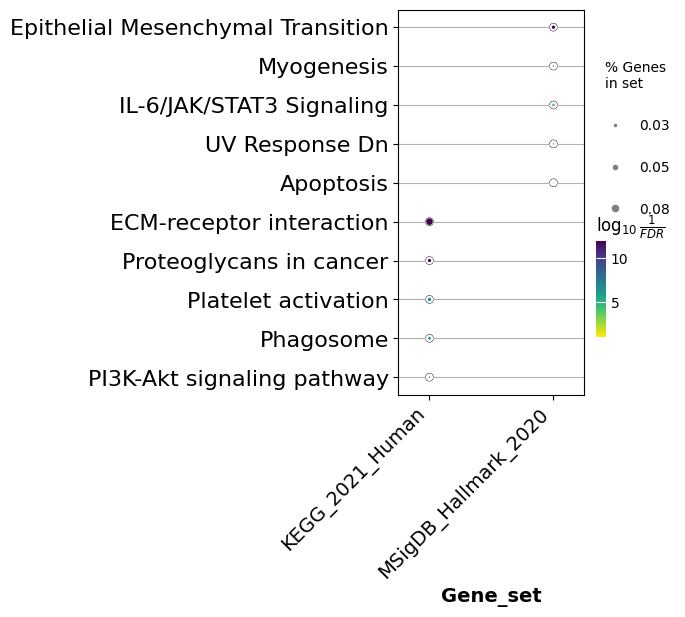

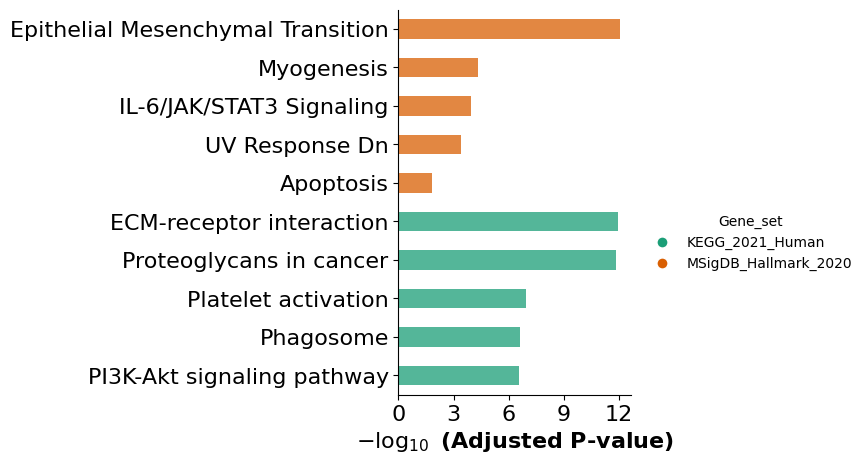

In [14]:
mmcci.plt.lrs_per_celltype(integrated, "Fibroblast", "KC Other", n=10, x_label_size=30, y_label_size=30)

pairs = mmcci.an.get_lrs_per_celltype(integrated, "Fibroblast", "KC Other")
mmcci.an.run_gsea(None, lrs=pairs, gene_sets=["KEGG_2021_Human", "MSigDB_Hallmark_2020"])

#### Find interactions involved in specific pathways

In [15]:
results = mmcci.an.run_gsea(integrated, gene_sets=["KEGG_2021_Human", "MSigDB_Hallmark_2020"], show_plots=False)

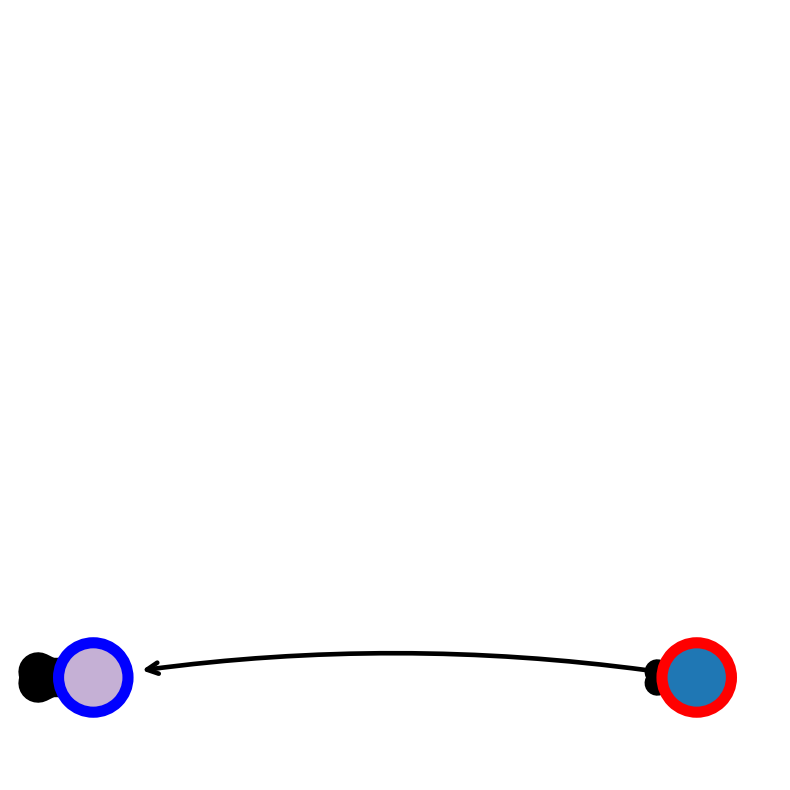

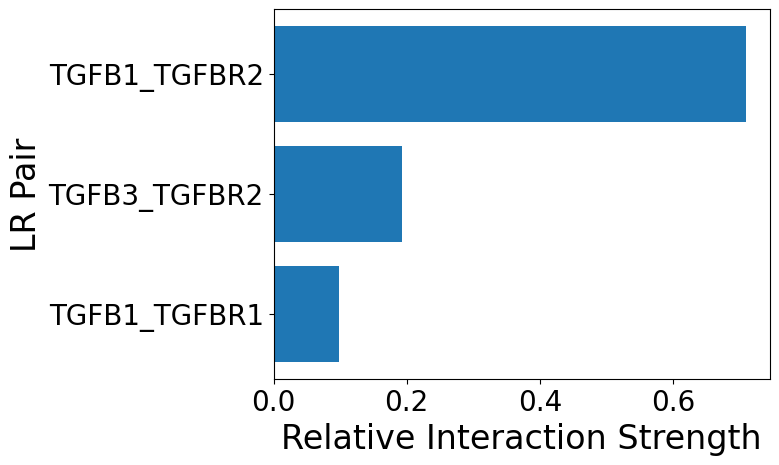

In [16]:
emt_grouped = mmcci.an.pathway_subset(integrated, results, ["TGF-beta signaling pathway"], strict=True)
emt_grouped_overall = mmcci.it.calculate_overall_interactions(emt_grouped)
mmcci.plt.network_plot(emt_grouped_overall, show_labels=False, node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors, remove_unconnected=False)

mmcci.plt.lr_barplot(emt_grouped, n=3)

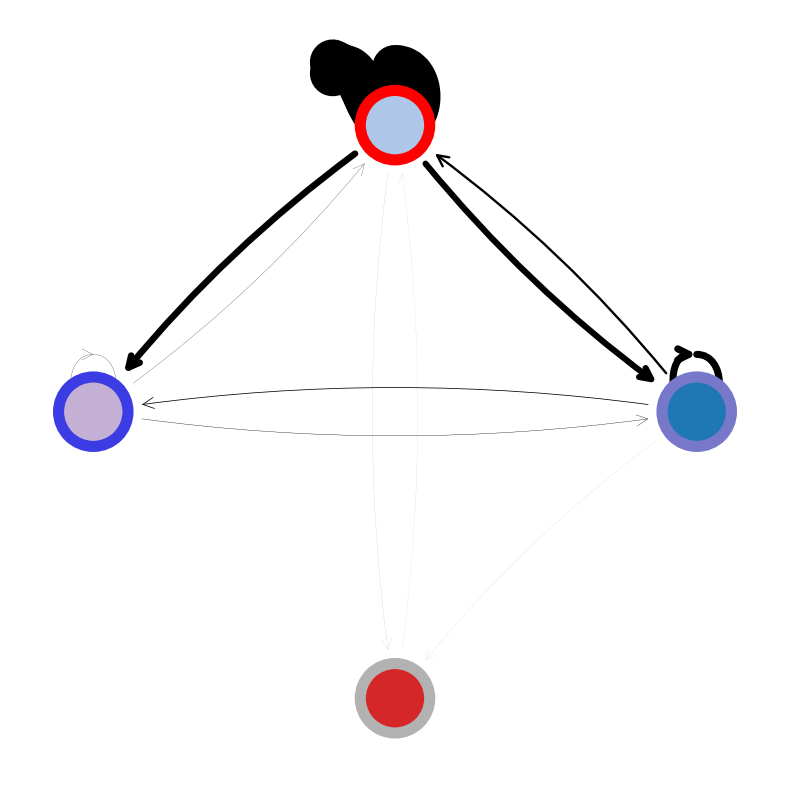

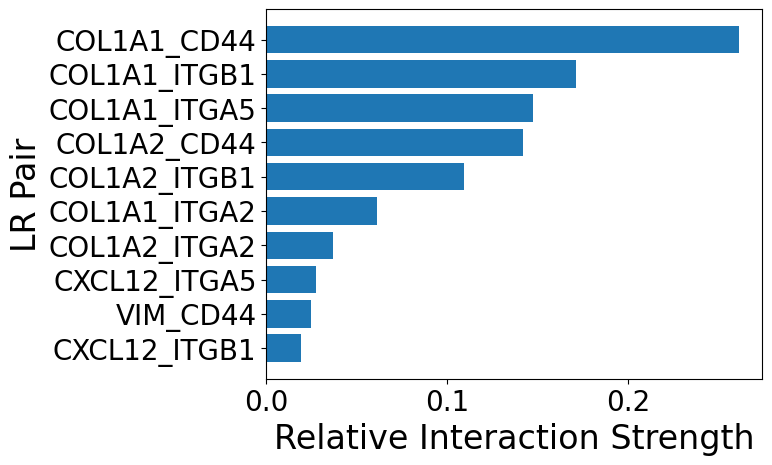

In [17]:
emt_grouped = mmcci.an.pathway_subset(integrated, results, ["Epithelial Mesenchymal Transition"], strict=True)
emt_grouped_overall = mmcci.it.calculate_overall_interactions(emt_grouped)
mmcci.plt.network_plot(emt_grouped_overall, show_labels=False, node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors, remove_unconnected=False)
mmcci.plt.lr_barplot(emt_grouped, n=10)

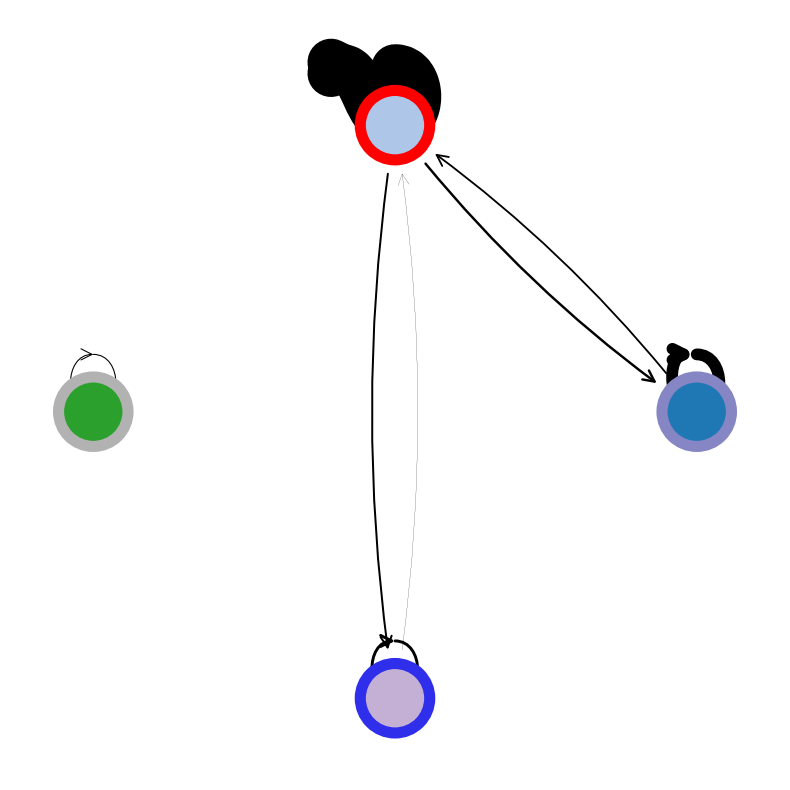

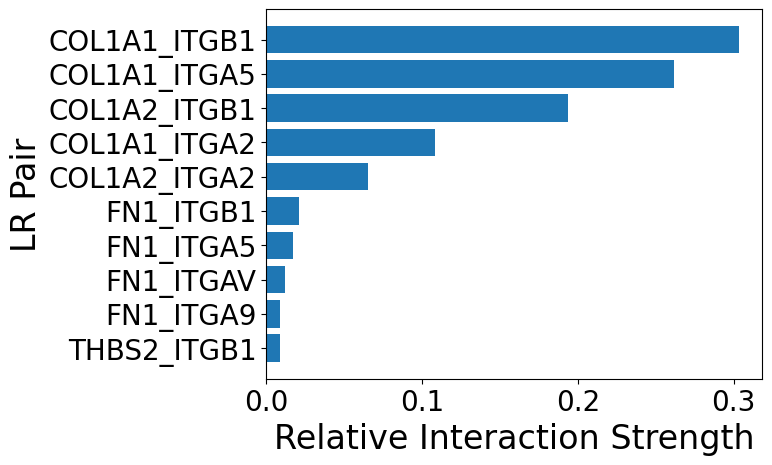

In [18]:
emt_grouped = mmcci.an.pathway_subset(integrated, results, ["PI3K-Akt signaling pathway"], strict=True)
emt_grouped_overall = mmcci.it.calculate_overall_interactions(emt_grouped)
mmcci.plt.network_plot(emt_grouped_overall, show_labels=False, node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors, remove_unconnected=False)
mmcci.plt.lr_barplot(emt_grouped, n=10)